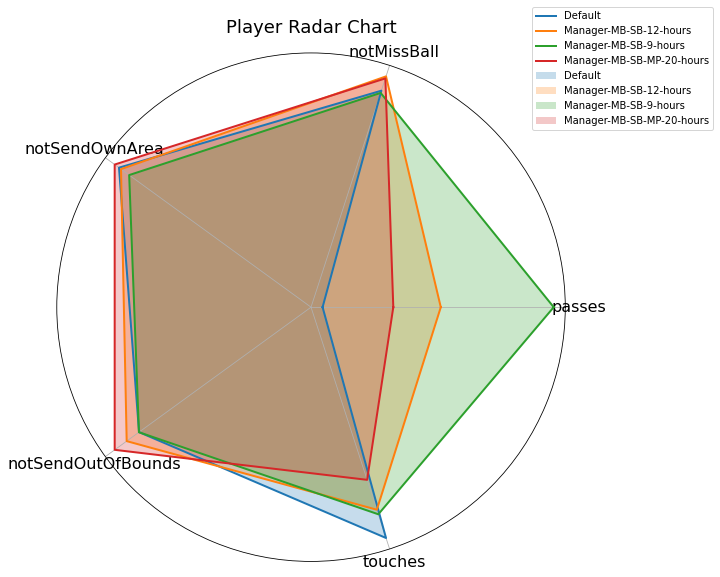

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict

# Read data from the file
file_path = "statistics.txt"
with open(file_path, "r") as file:
    data = file.read()

# Parse the data using regex
pattern = r"'([^']+)': \{'wins': (\d+), 'touches': (\d+), 'passes': (\d+), 'misses': (\d+), 'sendBallSuccess': (\d+), 'sendBallFail': (\d+), 'sendBallOut': (\d+)\}"
matches = re.findall(pattern, data)

# Extract player stats
player_stats = defaultdict(lambda: defaultdict(int))

score_stats = defaultdict(lambda: defaultdict(list))

for match in matches:
    key, wins, touches, passes, misses, sendBallSuccess, sendBallFail, sendBallOut = match
    player = key.split(" vs ")[0].replace('(Blue)', '').replace('(Purple)', '').strip()
    opponent = key.split(" vs ")[1].replace('(Blue)', '').replace('(Purple)', '').strip()
    player_stats[player]["passes"] += int(passes)
    player_stats[player]["notMissBall"] += 100 - (int(misses) / int(touches) * 100) if int(touches) > 0 else 0
    player_stats[player]["notSendOwnArea"] += 100 - (int(sendBallFail) / int(touches) * 100) if int(touches) > 0 else 0
    player_stats[player]["notSendOutOfBounds"] += 100 - (int(sendBallOut) / int(touches) * 100) if int(touches) > 0 else 0
    player_stats[player]["touches"] += int(touches)

    score_stats[player][opponent].append(int(wins))
    

# Average rates across matches for each player
for player, stats in sorted(player_stats.items()):
    if stats["touches"] > 0:  # Avoid division by zero
        stats["notMissBall"] /= stats["touches"]
        stats["notSendOwnArea"] /= stats["touches"]
        stats["notSendOutOfBounds"] /= stats["touches"]

# Normalize stats for radar chart
categories = ["passes", "notMissBall", "notSendOwnArea", "notSendOutOfBounds", "touches"]
max_values = {key: max(stats[key] for stats in player_stats.values()) for key in categories}

normalized_stats = {}
for player, stats in sorted(player_stats.items()):
    normalized_stats[player] = {key: stats[key] / max_values[key] if max_values[key] > 0 else 0 for key in categories}

# Create a radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Define angles for radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart

# Plot each player
for player, stats in sorted(normalized_stats.items()):
    values = list(stats.values())
    values += values[:1]  # Close the radar chart
    ax.fill(angles, values, alpha=0.25, label=player)
    ax.plot(angles, values, linewidth=2, label=player)

# Add labels and legend
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=16)
ax.set_title("Player Radar Chart", size=18, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig("player_radar_chart.png")
plt.show()

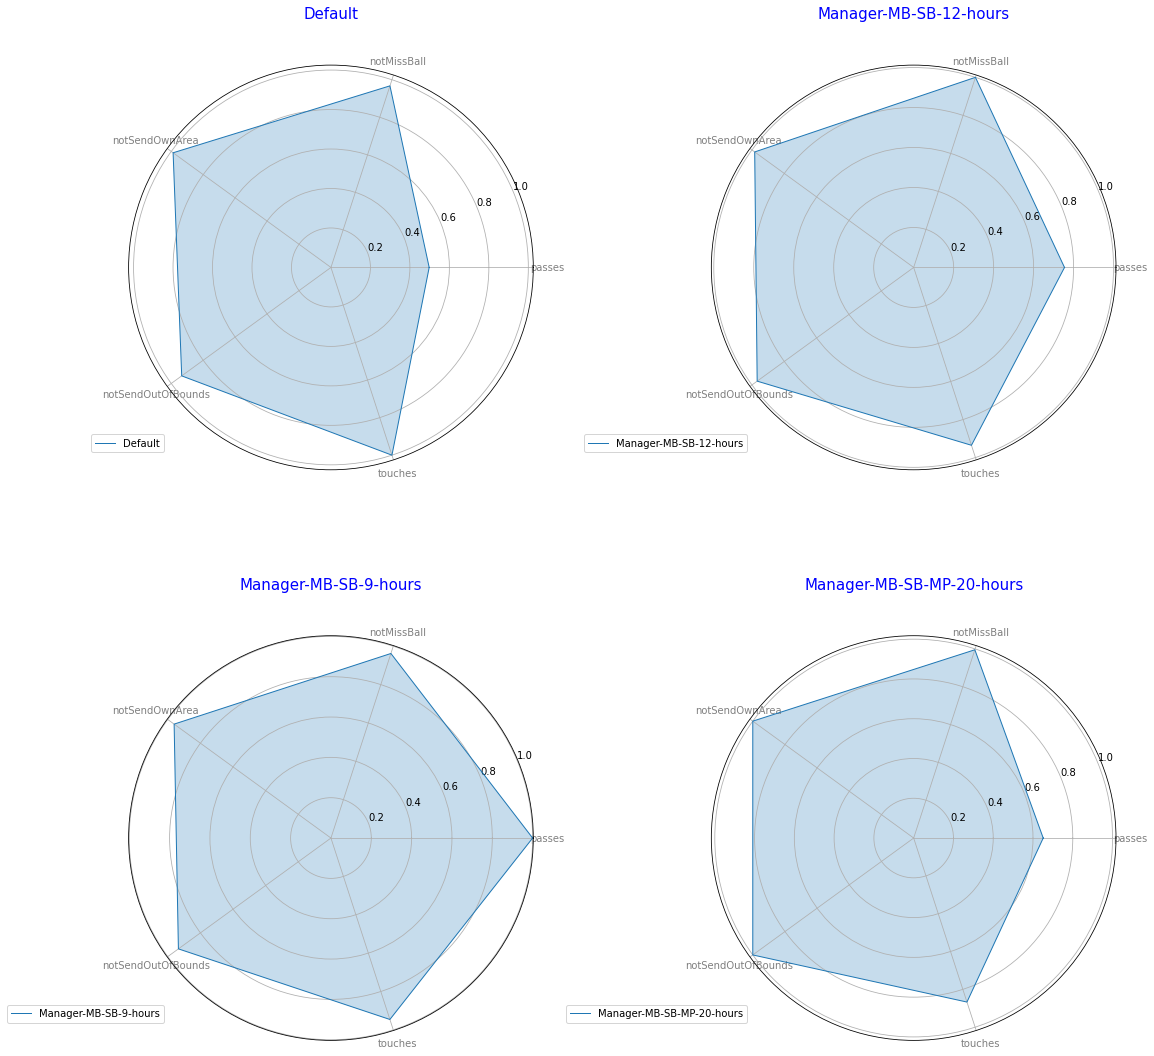

In [3]:
# Radar chart plot function
def plot_radar_chart(ax, data, player_name, fields):
    angles = np.linspace(0, 2 * np.pi, len(fields), endpoint=False).tolist()
    angles += angles[:1]

    values = list(data[player_name].values())
    values += values[:1]

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(fields, color='grey', size=10)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=player_name)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(player_name, size=15, color='blue', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Fields of interest
fields = ["passes", "notMissBall", "notSendOwnArea", "notSendOutOfBounds", "touches"]

# Normalize the player data
normalized_player_data = normalized_stats

# Create a 2x2 grid of radar charts
fig, axs = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(polar=True))

# Plot individual radar charts for each player
for ax, player in zip(axs.flatten(), normalized_player_data):
    plot_radar_chart(ax, normalized_player_data, player, fields)

plt.tight_layout()
plt.savefig("individual_radar_charts.png")
plt.show()

defaultdict(<function <lambda> at 0x000001AACA144670>, {'Manager-MB-SB-MP-20-hours': defaultdict(<class 'list'>, {'Manager-MB-SB-MP-20-hours': [11, 4, 11, 9, 11, 10, 11, 3, 11, 8, 11, 8, 11, 10], 'Default': [11, 10, 6, 7, 8, 4, 5, 6, 11, 8, 10, 8], 'Manager-MB-SB-12-hours': [11, 11, 6, 11, 8, 11, 8, 11, 11, 11, 7], 'Manager-MB-SB-9-hours': [10, 11, 9, 4, 5, 11, 11, 11, 9, 10, 11]}), 'Default': defaultdict(<class 'list'>, {'Manager-MB-SB-MP-20-hours': [6, 11, 11, 11, 11, 11, 11, 11, 10, 11, 11, 11], 'Manager-MB-SB-12-hours': [11, 9, 11, 7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], 'Manager-MB-SB-9-hours': [11, 11, 11, 11, 11, 11, 11, 11, 11, 9, 11, 11, 11], 'Default': [11, 8, 11, 6, 11, 4, 11, 6, 11, 10, 11, 9]}), 'Manager-MB-SB-9-hours': defaultdict(<class 'list'>, {'Manager-MB-SB-12-hours': [11, 11, 10, 10, 11, 11, 6, 8, 6, 5, 5, 11], 'Manager-MB-SB-9-hours': [11, 10, 11, 7, 11, 9, 11, 3, 11, 5, 11, 9, 11, 4], 'Default': [5, 6, 6, 5, 5, 3, 6, 4, 2, 11, 6, 9, 10], 'Manager-MB-SB-MP-20-h

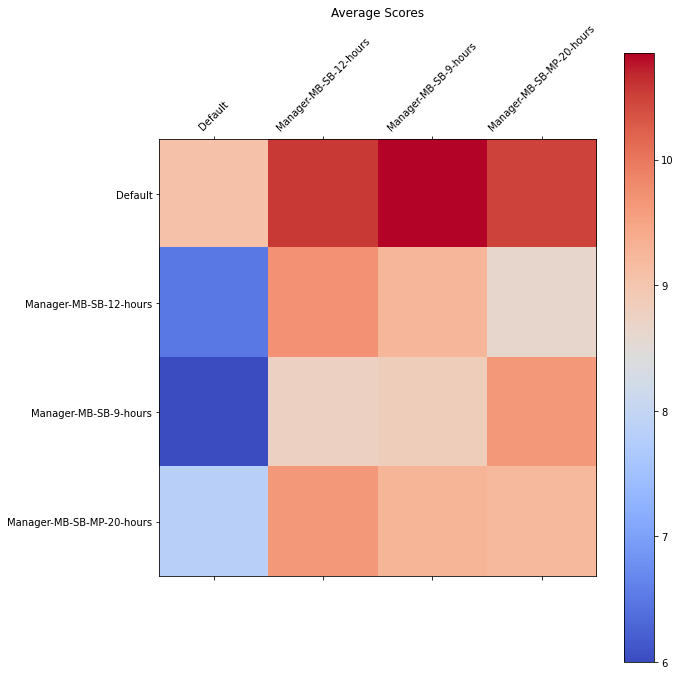

In [ ]:
players = sorted(player_stats.keys())

print(score_stats)

average_score_stats = {player: {opponent: sum(scores) / len(scores) for opponent, scores in stats.items()} for player, stats in score_stats.items()}
print(average_score_stats)

# Create a heatmap of average scores
fig, ax = plt.subplots(figsize=(10, 10))

# Create a matrix of average scores
average_scores = np.array([[average_score_stats[player][opponent] for opponent in players] for player in players])

# Plot the heatmap and put average scores in the heatmap
cax = ax.matshow(average_scores, cmap='coolwarm')

# Add labels
ax.set_xticks(range(len(players)))
ax.set_yticks(range(len(players)))
ax.set_xticklabels(players, rotation=45)
ax.set_yticklabels(players)
fig.colorbar(cax)

plt.title("Average Scores")
plt.tight_layout()
plt.savefig("average_scores_heatmap.png")
plt.show()


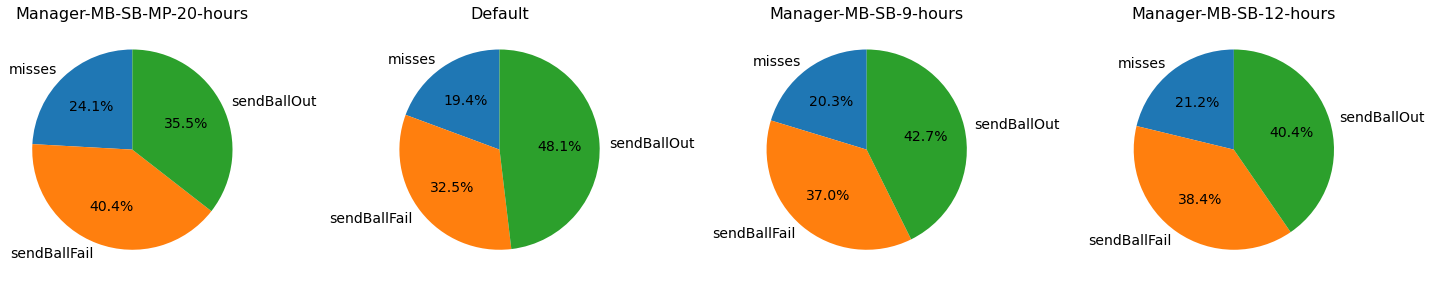

In [10]:
import pandas as pd
# Calculate the total number of misses, sendBallFail, and sendBallOut for each player
cause_events = defaultdict(lambda: defaultdict(int))

for match in matches:
    key, wins, touches, passes, misses, sendBallSuccess, sendBallFail, sendBallOut = match
    player = key.split(" vs ")[0].replace('(Blue)', '').replace('(Purple)', '').strip()
    cause_events[player]["misses"] += int(misses)
    cause_events[player]["sendBallFail"] += int(sendBallFail)
    cause_events[player]["sendBallOut"] += int(sendBallOut)

# Convert the cause events to a DataFrame for easier plotting
cause_events_df = pd.DataFrame(cause_events).T
cause_events_df = cause_events_df[['misses', 'sendBallFail', 'sendBallOut']]

# Plot the distribution of cause events for losing points for each player as a pie chart
fig, axs = plt.subplots(1, len(cause_events_df), figsize=(20, 10))

for ax, (player, row) in zip(axs, cause_events_df.iterrows()):
    row.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, legend=False, textprops={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_title(player, fontsize=16)

plt.tight_layout()
plt.savefig("cause_events_pie_chart.png")
plt.show()
